# Fetch Data API Client

__Purpose is to make an API and program to fetch data from Kaggle__

## Kaggle Halite API Endpoints

In [53]:
# Kaggle Limits (https://www.kaggle.com/c/halite/discussion/164932)
#    1000 requests per day max;  Rate limits are shared between the ListEpisodes and GetEpisodeReplay endpoints
#    Exceeding limits repeatedly will lead to temporary and then permanent bans

Kaggle's Sam Harris release an API to pull Halite match data from games hosted on Kaggle.
- Post documenting API: https://www.kaggle.com/c/halite/discussion/164932
- API Wrapper here: https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/api.py
- API service is located at: https://www.kaggle.com/requests/EpisodeService/

#### GetEpisodeReplay Endpoint

- URL: 'https://www.kaggle.com/requests/EpisodeService/GetEpisodeReplay'
- Verb: Post
- Schema: JSON
- JSON Payload: {"EpisodeId": episode_id} # int

#### ListEpisodes Endpoint

- URL: 'https://www.kaggle.com/requests/EpisodeService/ListEpisodes'
- Verb: Post
- Schema: JSON
- JSON Payload:
    - {"Ids": episode_ids} # List[int]
    - {"TeamId": team_id} # int
    - {"SubmissionId": submission_id} # int

In [ ]:
base_url = "https://www.kaggle.com/requests/EpisodeService/"
get_url = base_url + "GetEpisodeReplay"
list_url = base_url + "ListEpisodes"

In [ ]:
import requests

from typing import *

base_url = "https://www.kaggle.com/requests/EpisodeService/"
get_url = base_url + "GetEpisodeReplay"
list_url = base_url + "ListEpisodes"


def get_episode_replay(episode_id: int):
    body = {
        "EpisodeId": episode_id
    }

    response = requests.post(get_url, json=body)
    return response.json()


def list_episodes(episode_ids: List[int]):
    return __list_episodes({
        "Ids": episode_ids
    })


def list_episodes_for_team(team_id: int):
    return __list_episodes({
        "TeamId": team_id
    })


def list_episodes_for_submission(submission_id: int):
    return __list_episodes({
        "SubmissionId": submission_id
    })


def __list_episodes(body):
    response = requests.post(list_url, json=body)
    return response.json()

In [48]:
__version__ = '0.0.1'


from urllib.parse import urljoin
import inspect
import requests

class KaggleClient(object):
    """ A Kaggle Halite Episode Service API wrapper. """
    
    def __init__(self):
        self.requester = self.Requester()
        self._attach_endpoints()
        
    def _attach_endpoints(self):
        """ Generate and attach endpoints """
        for name, endpoint in inspect.getmembers(self):
            if (inspect.isclass(endpoint) 
                and issubclass(endpoint, self._Endpoint) 
                and endpoint is not self._Endpoint):
                endpoint_instance = endpoint(self.requester)
                setattr(self, endpoint.name, endpoint_instance)
    
    class Requester(object):
        """ An object for making API requests """
        
        def GET(self, url, params=None, json=None):
            if None is params:
                params = dict()
            if None is json:
                json = dict()
    
            params.setdefault('datatype', 'json')
            response = requests.post(url, params=params, json=json)
            if 200 != response.status_code:
                error = 'HTTPError: {}'.format(response.status_code)
                return {'success': False, 'error': error}
            try:
                return response.json()
            except ValueError as err:
                return {'success': False, 'error': err}
        
    class _Endpoint(object):
        """ Base class of an endpoint """
        url = 'https://www.kaggle.com/requests/EpisodeService/'
        
        def __init__(self, requester):
            self.requester = requester            
        
        def _GET(self, path, params=None, json=None):
            request_url = urljoin(self.url, path)
            #print(f'url: {self.url}, request_url: {request_url}, path: {path}')
            return self.requester.GET(request_url, params, json)
    
    class Replay(_Endpoint):
        name = 'replay'
        
        def episode(self, episode_id, params=None):
            json = {"EpisodeId": episode_id}
            return self._GET('GetEpisodeReplay', params, json)
        
    class Episodes(_Endpoint):
        name = 'episodes'

        def episodes(self, episode_ids, params=None):
            json = {'Ids': episode_ids}
            return self._GET('ListEpisodes', params, json)
        
        def team(self, team_id, params=None):
            json = {'TeamId': team_id}
            return self._GET('ListEpisodes', params, json)
        
        def submission(self, submission_id, params=None):
            json = {'SubmissionId': submission_id}
            return self._GET('ListEpisodes', params, json)

In [49]:
api = KaggleClient()

In [41]:
json = api.episodes.team(TEAM_ID)

In [42]:
json.keys()

dict_keys(['result', 'wasSuccessful'])

In [44]:
json['result'].keys()

dict_keys(['episodes', 'teams'])

In [46]:
json['result']['episodes'][0].keys()

dict_keys(['id', 'competitionId', 'createTime', 'endTime', 'replayUrl', 'adminNotes', 'state', 'type', 'agents'])

In [4]:
NUM_TEAMS = 1
EPISODES = 300
MIN_RATING = 1000

### Initialize

In [5]:
# !pip install kaggle-environments --upgrade

In [5]:
import pandas as pd
import numpy as np
import os

In [6]:
import requests
import json
from zipfile import ZipFile

In [7]:
import datetime
import time

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 4)

In [9]:
base_url = "https://www.kaggle.com/requests/EpisodeService/"
get_url = base_url + "GetEpisodeReplay"
list_url = base_url + "ListEpisodes"

### Get Initial Team List

In [24]:
def get_teams(team_id):
    r = requests.post(list_url, json = {"teamId":  5118174})
    rj = r.json()
    teams_df = pd.DataFrame(rj['result']['teams'])
    teams_df.sort_values('publicLeaderboardRank', inplace = True)
    return teams_df

In [25]:
TEAM_ID = 5118174

In [26]:
df = get_teams(TEAM_ID)

In [33]:
df.shape

(430, 20)

In [27]:
df.head()

,competition,competitionId,createdAfterDeadline,dateMedalAwarded,id,inboundMergeRequests,isBenchmark,lastSubmissionDate,medal,outboundMergeRequests,privateLeaderboardRank,privateLeaderboardScore,privateLeaderboardSubmissionId,publicLeaderboardRank,publicLeaderboardScore,publicLeaderboardSubmissionId,submissionCount,teamLeaderId,teamMembers,teamName
107,None,18011,False,None,5118779,[],False,"{'seconds': 1594329190, 'nanos': 513333300}",0,[],None,None,None,1,None,16454608,9,80203,[],mzotkiew
208,None,18011,False,None,5133228,[],False,"{'seconds': 1594936671, 'nanos': 950000000}",0,[],None,None,None,2,None,16425049,26,5330482,[],Robiland
21,None,18011,False,None,4820508,[],False,"{'seconds': 1594939322, 'nanos': 340000000}",0,[],None,None,None,3,None,16362931,60,4941914,[],Team VQ
147,None,18011,False,None,5124482,[],False,"{'seconds': 1594292899, 'nanos': 0}",0,[],None,None,None,4,None,16449795,11,4788543,[],Sergey Stupin
7,None,18011,False,None,4714287,[],False,"{'seconds': 1594416886, 'nanos': 153333300}",0,[],None,None,None,5,None,16466155,2,582611,[],Tom Van de Wiele


In [17]:
def getTeamEpisodes(team_id):
    # request
    r = requests.post(list_url, json = {"teamId":  int(team_id)})
    rj = r.json()

    # update teams list
    global teams_df
    teams_df_new = pd.DataFrame(rj['result']['teams'])
    
    if len(teams_df.columns) == len(teams_df_new.columns) and (teams_df.columns == teams_df_new.columns).all():
        teams_df = pd.concat( (teams_df, teams_df_new.loc[[c for c in teams_df_new.index if c not in teams_df.index]] ) )
        teams_df.sort_values('publicLeaderboardRank', inplace = True)
#         print('{} teams on file'.format(len(teams_df)))
    else:
        print('teams dataframe did not match')
    
    # make df
    team_episodes = pd.DataFrame(rj['result']['episodes'])
    team_episodes['avg_score'] = -1;
    
    for i in range(len(team_episodes)):
        agents = team_episodes['agents'].loc[i]
        agent_scores = [a['updatedScore'] for a in agents if a['updatedScore'] is not None]
        if len(agent_scores) > 0:
            team_episodes.loc[i, 'avg_score'] = np.mean(agent_scores)

    team_episodes.sort_values('avg_score', ascending = False, inplace=True)
    return rj, team_episodes

In [18]:
def saveEpisode(epid, rj):
    # request
    re = requests.post(get_url, json = {"EpisodeId": int(epid)})
    
    # save replay
    with open('{}.json'.format(epid), 'w') as f:
        f.write(re.json()['result']['replay'])

    # save episode info
    with open('{}_info.json'.format(epid), 'w') as f:
        json.dump([r for r in rj['result']['episodes'] if r['id']==epid][0], f)

### Scraper

In [19]:
all_files = []
for root, dirs, files in os.walk('../input/', topdown=False):
    all_files.extend(files)

In [20]:
seen_episodes = [int(f.split('.')[0]) for f in all_files 
                      if '.' in f and f.split('.')[0].isdigit() and f.split('.')[1] == 'json']

In [21]:
print('{} games in existing library'.format(len(seen_episodes)))

3450 games in existing library


8607 games for Team VQ
   4737 with top competition
      2194 remain to be downloaded

Saved Episode #1506751 @ 2.2MB
Saved Episode #1506726 @ 2.1MB
Saved Episode #1506451 @ 2.3MB
Saved Episode #1506461 @ 2.2MB
Saved Episode #1506160 @ 2.1MB
Saved Episode #1506565 @ 2.2MB
Saved Episode #1506718 @ 2.1MB
Saved Episode #1506125 @ 2.2MB
Saved Episode #1506704 @ 2.2MB
Saved Episode #1506706 @ 2.0MB
Saved Episode #1506743 @ 2.1MB
Saved Episode #1474264 @ 2.1MB
Saved Episode #1314364 @ 1.9MB
Saved Episode #1480700 @ 2.1MB
Saved Episode #1382463 @ 2.2MB
Saved Episode #1463325 @ 2.3MB
Saved Episode #1331011 @ 2.0MB
Saved Episode #1279811 @ 2.0MB
Saved Episode #1220385 @ 2.0MB
Saved Episode #1389284 @ 2.3MB
Saved Episode #1422077 @ 2.0MB
Saved Episode #1385812 @ 2.1MB
Saved Episode #1499655 @ 2.0MB
Saved Episode #1276599 @ 2.0MB
Saved Episode #1321688 @ 1.9MB
Saved Episode #1394517 @ 2.3MB
Saved Episode #1343739 @ 2.1MB
Saved Episode #1498730 @ 1.8MB
Saved Episode #1343091 @ 1.8MB
Saved Episode

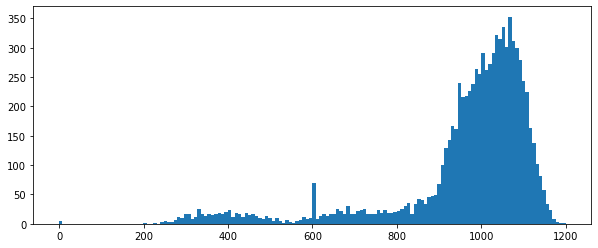

In [22]:
pulled_teams = {}
pulled_episodes = []
start_time = datetime.datetime.now()
r = 0;

while len(pulled_episodes) < EPISODES:
    # pull team
    top_teams = [i for i in teams_df.id if i not in pulled_teams]
    if len(top_teams) > 0:
        team_id = top_teams[0]
    else:
        break;
        
    # get team data
    team_json, team_df = getTeamEpisodes(team_id); r+=1;
    print('{} games for {}'.format(len(team_df), teams_df.loc[teams_df.id == team_id].iloc[0].teamName))
    plt.hist(team_df.avg_score, bins = 150);
    
    team_df = team_df[team_df.avg_score > MIN_RATING]
    print('   {} with top competition'.format(len(team_df)))
    
    team_df = team_df[~team_df.id.isin(pulled_episodes + seen_episodes)]        
    print('      {} remain to be downloaded\n'.format(len(team_df)))
    
    # pull games
    target_team_games = int(np.ceil(EPISODES / NUM_TEAMS))
    if target_team_games + len(pulled_episodes) > EPISODES:
        target_team_games = EPISODES - len(pulled_episodes)
     
    pulled_teams[team_id] = 0
    
    i = 0
    while i < len(team_df) and pulled_teams[team_id] < target_team_games:
        epid = team_df.id.iloc[i]
        if not (epid in pulled_episodes or epid in seen_episodes):
            saveEpisode(epid, team_json); r+=1;
            pulled_episodes.append(epid)
            pulled_teams[team_id] += 1
            try:
                size = os.path.getsize('{}.json'.format(epid)) / 1e6
                print('Saved Episode #{} @ {:.1f}MB'.format(epid, size))
            except:
                print('  file {}.json did not seem to save'.format(epid))    
            if r > (datetime.datetime.now() - start_time).seconds:
                time.sleep( r - (datetime.datetime.now() - start_time).seconds)
                

        i+=1;
    print(); print()

In [23]:
print('\n   Post and share your datasets publicly on this thread:')
print('        https://www.kaggle.com/c/halite/discussion/164932\n')


   Post and share your datasets publicly on this thread:
        https://www.kaggle.com/c/halite/discussion/164932



### Check JSON

In [24]:
file = './{}.json'.format(epid)

In [25]:
with open(file) as f:
    data = json.load(f)

In [26]:
data['rewards']

[5262, 828, 8294, 574]